---
title: "Forecasting Energy Consumption with XGBoost"
author: "Daniel Smith"
date: "2023-12-22"
categories: [Python, XGBoost, Time Series Forecasting]
title-block-banner: false
jupyter: python3
image: 'preview.png'
---

Informed by YouTube videos of [Rob Mulla](https://www.youtube.com/@robmulla) we use XGBoost to forecast energy consumption in the eastern US.

In [2]:
import numpy as np 
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
color_pal = sns.color_palette('magma')

# Sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# Model
import xgboost as xgb

# Data

The data can be downloaded [here](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption). According to the Kaggle page:

> PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.
The hourly power consumption data comes from PJM's website and are in megawatts (MW).

In [3]:
df = pd.read_csv('PJME_hourly.csv')

In [4]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [6]:
df.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


Use the 'Datetime' column as the dataframe index, and convert to the `Datetime` type

In [7]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


In [9]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


Text(0, 0.5, 'Energy Consumption (MW)')

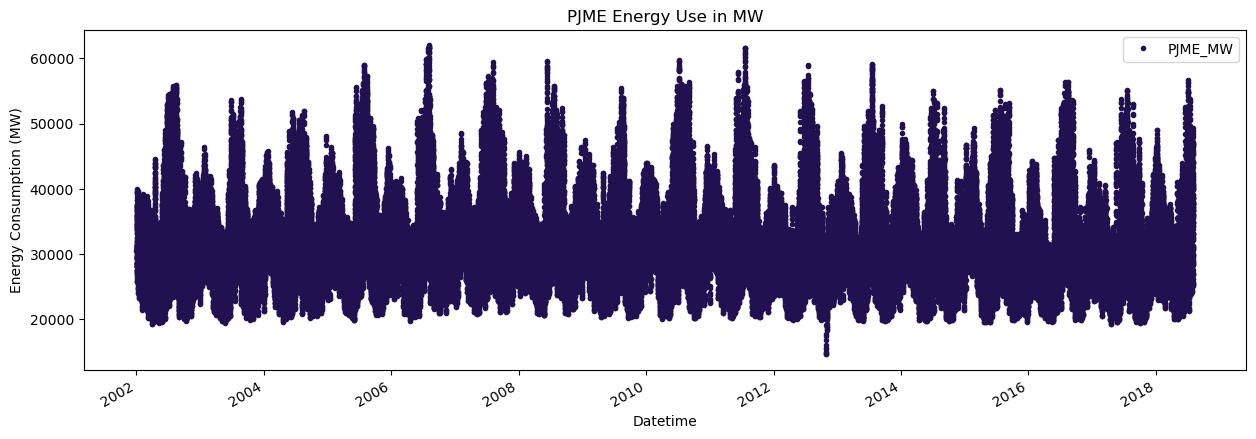

In [10]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.ylabel('Energy Consumption (MW)')

# Periodic Trends

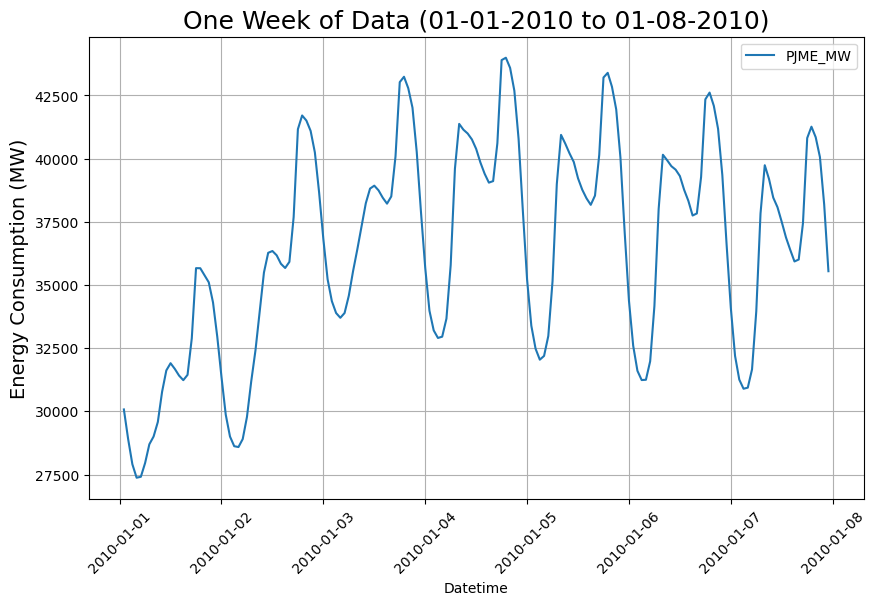

In [11]:
week = df.loc[(df.index >'01-01-2010') & (df.index < '01-08-2010')]

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=week, ax=ax)
plt.title('One Week of Data (01-01-2010 to 01-08-2010)', fontsize=18)
plt.ylabel('Energy Consumption (MW)', fontsize=14)

plt.xticks(rotation=45)
plt.grid(True)

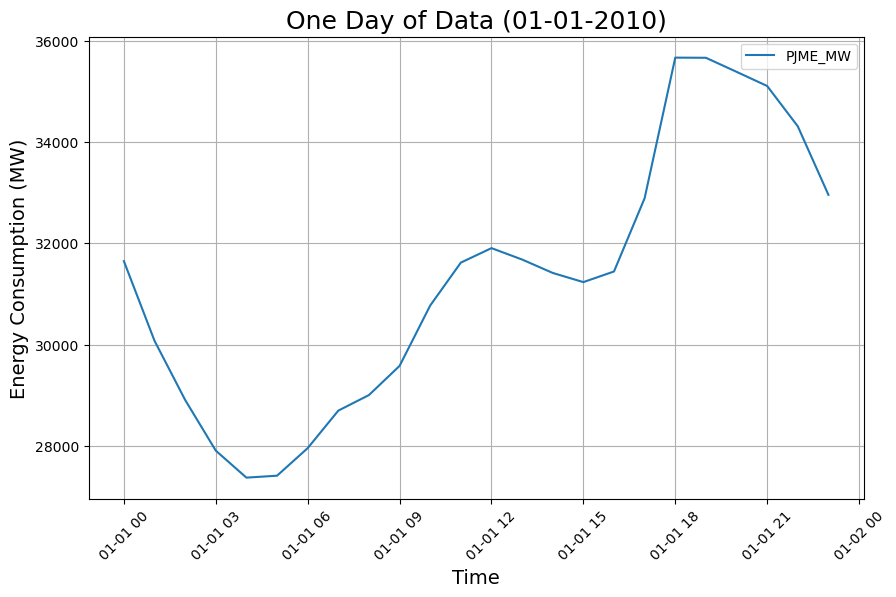

In [12]:
selected_date = '01-01-2010'
selected_day = df.loc[selected_date]

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=selected_day, ax=ax)
plt.title(f'One Day of Data ({selected_date})', fontsize=18)

plt.xlabel('Time', fontsize=14)
plt.ylabel('Energy Consumption (MW)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)

One might worry that new year's day might not be a typical day for energy consumption.

Repeating this plot for the first of February:

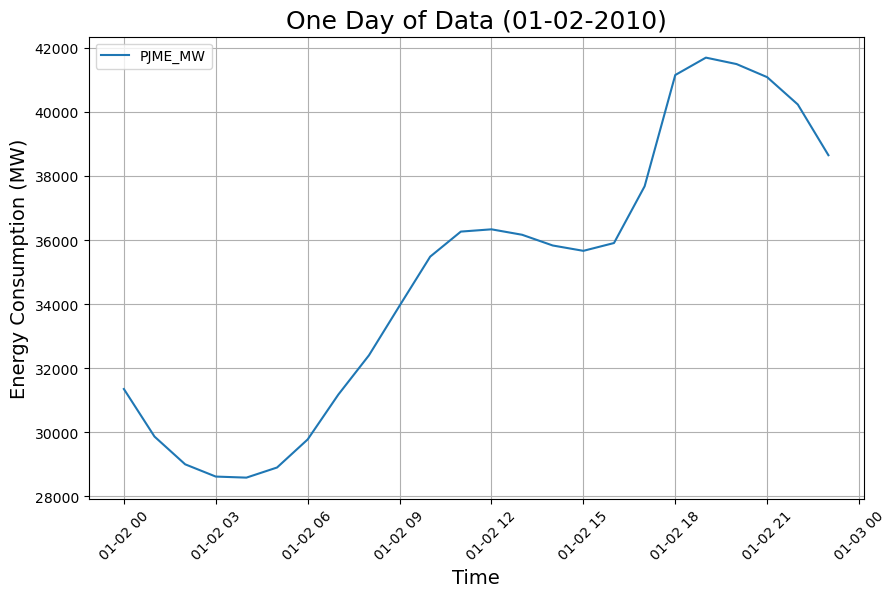

In [13]:
selected_date = '01-02-2010'
selected_day = df.loc[selected_date]

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=selected_day, ax=ax)

plt.title(f'One Day of Data ({selected_date})', fontsize=18)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Energy Consumption (MW)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)

It seems that the daily trend seems to be the same.

To be sure, we repeat this plot once more for four randomly chosen dates in 2005-2010:

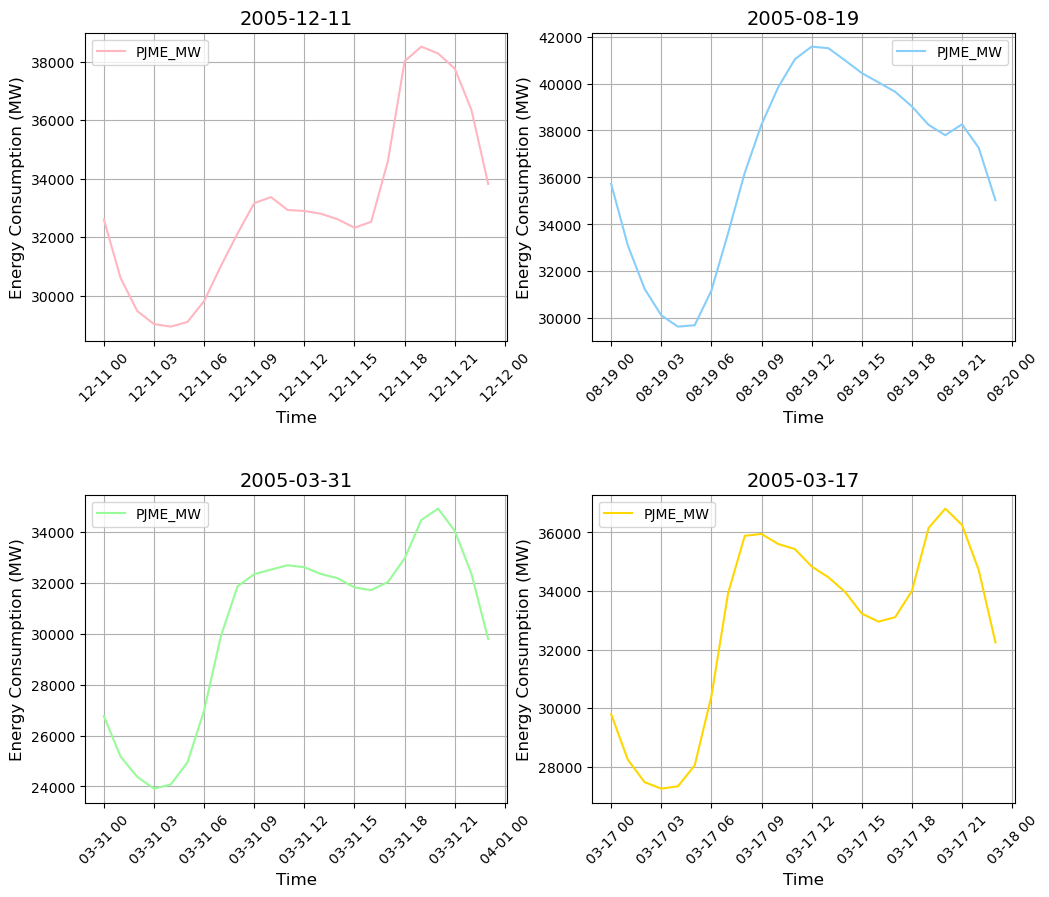

In [14]:
start_date = '01-01-2005'
end_date = '12-31-2010'

date_range = pd.date_range(start=start_date, end=end_date)

fig, axs = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw={'hspace': 0.5})
axs = axs.flatten()
colors = ['#FFB6C1', '#87CEFA', '#98FB98', '#FFD700']

for i in range(4):
    # Choose a random day
    random_date = pd.to_datetime(np.random.choice(date_range))
    day_data = df[df.index.date == random_date.date()]

    # Create a subplot
    ax = axs[i]

    sns.lineplot(data=day_data, ax=ax, palette=[colors[i]])

    ax.set_title(f'{random_date.date()}', fontsize=14)
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Energy Consumption (MW)', fontsize=12)

    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)

Unsuprisingly, the time of year seems to have a significant impact on daily energy consumption patterns.

The very general trend of less energy consumption at night compared with in the day seems however to persist across the year.

Creating another 2x2 grid, this time plotting the energy consumption across random weeks in 2005-2010:

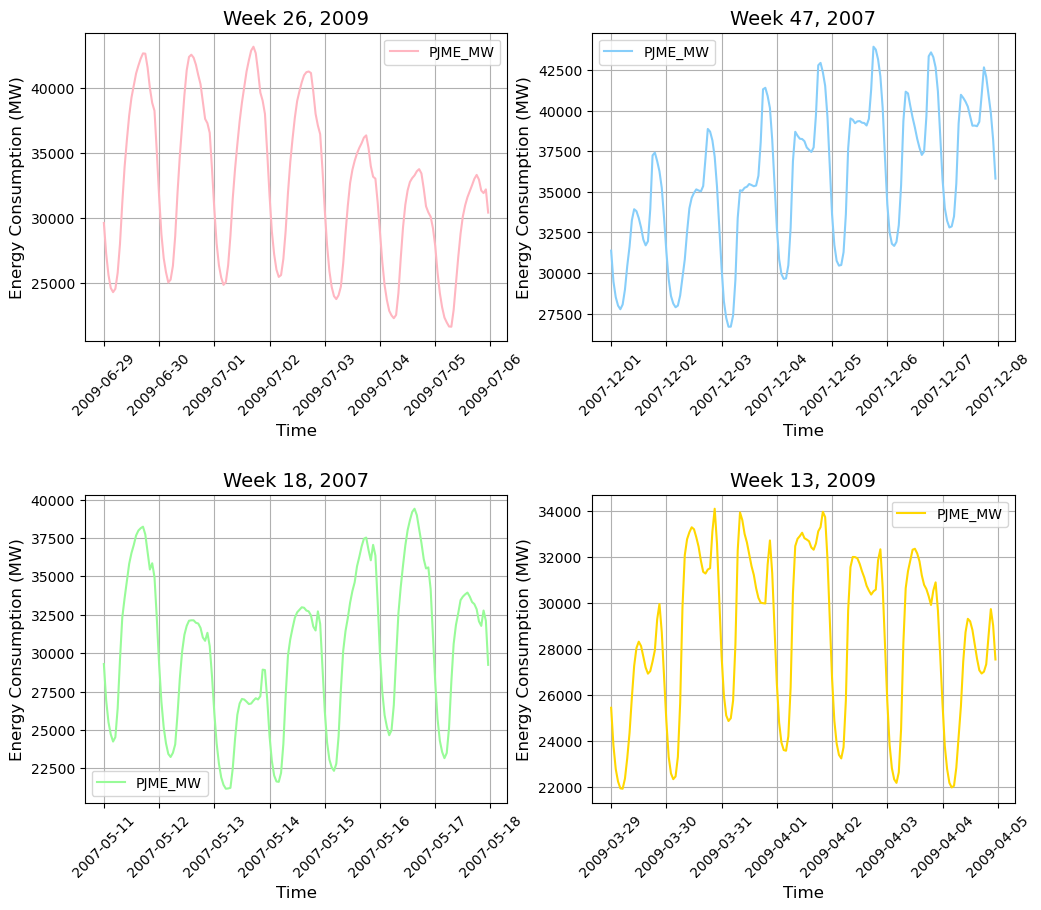

In [15]:
start_date = '01-01-2005'
end_date = '12-31-2010'

date_range = pd.date_range(start=start_date, end=end_date)

fig, axs = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw={'hspace': 0.5})
axs = axs.flatten()
colors = ['#FFB6C1', '#87CEFA', '#98FB98', '#FFD700']

for i in range(4):
    # Choose a random week
    random_start_date = pd.to_datetime(np.random.choice(date_range))
    start_date = random_start_date
    end_date = start_date + pd.DateOffset(days=7)
    week_data = df.loc[(df.index >= start_date) & (df.index < end_date)]
    
    # Create a subplot
    ax = axs[i]

    sns.lineplot(data=week_data, ax=ax, palette=[colors[i]])
    
    week_year_string = start_date.strftime('Week %U, %Y')
    
    ax.set_title(f'{week_year_string}', fontsize=14)
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Energy Consumption (MW)', fontsize=12)

    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)
    
plt.savefig('header.png')

# Outlier Analysis and Removal

Text(0.5, 0, 'Energy Consumption (MW)')

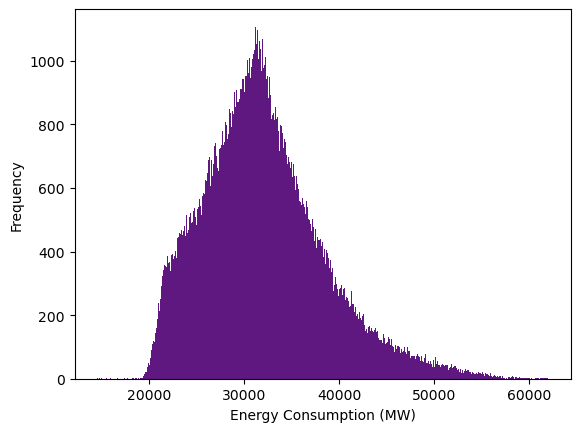

In [16]:
df['PJME_MW'].plot(kind='hist',
                   bins=500,
                   color=color_pal[1])
plt.xlabel('Energy Consumption (MW)')

<Axes: xlabel='Datetime'>

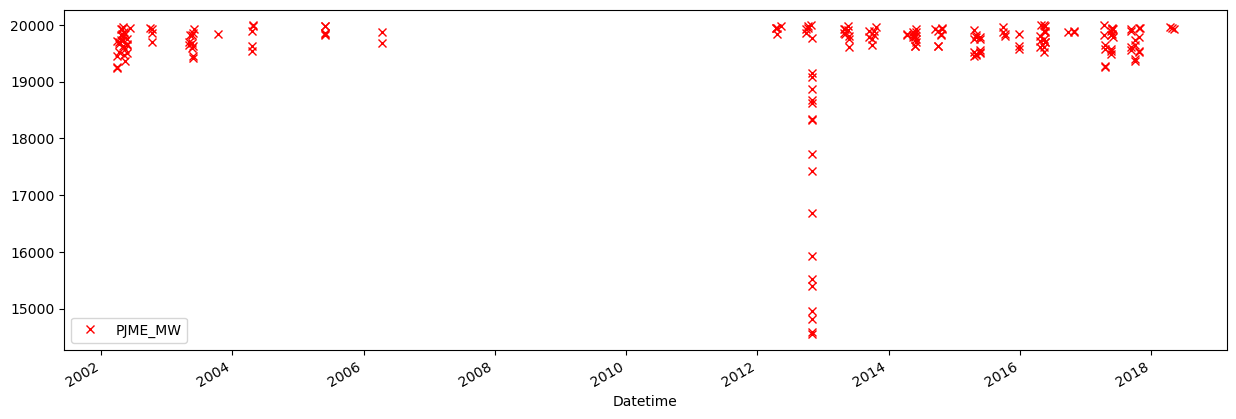

In [17]:
df.query('PJME_MW < 20_000').plot(figsize=(15,5),
                                  style='x',
                                  color='r')

The data points sitting signficantly below 20,000 in 2013 seem to be highly suspect.

Lower the query threshold to 19,00 in an attempt to isolate these points:

<Axes: xlabel='Datetime'>

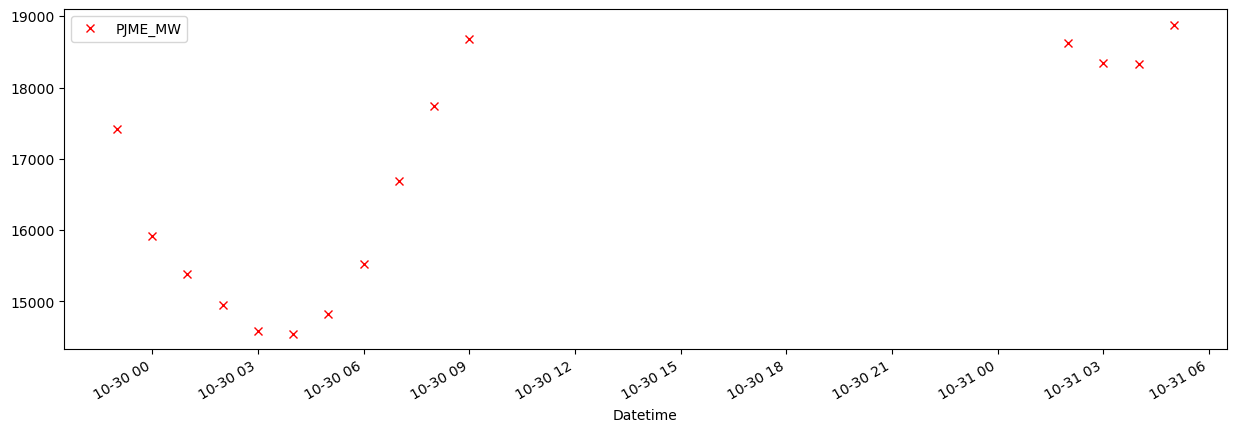

In [18]:
df.query('PJME_MW < 19_000').plot(figsize=(15,5),
                                  style='x',
                                  color='r')

We've successfully isolated these outliers, now filtering them out:

In [19]:
df = df.query('PJME_MW >= 19_000').copy()

In [20]:
len(df.query('PJME_MW < 19_000'))

0

# Feature Creation

In [21]:
def create_features(df):
    '''
    Create time series features using pd DateTime object methods on dataframe index
    '''
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [22]:
df = create_features(df)

In [23]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1


# Lag Features

In [24]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [25]:
df = add_lags(df)

In [26]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,30393.0,NaN,NaN
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,29265.0,NaN,NaN
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,28357.0,NaN,NaN
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,27899.0,NaN,NaN
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,28057.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,34600.0,41772.0,40740.0
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,33674.0,41393.0,40049.0
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,32035.0,40092.0,38473.0


# Visualising Feature/Target Relationships

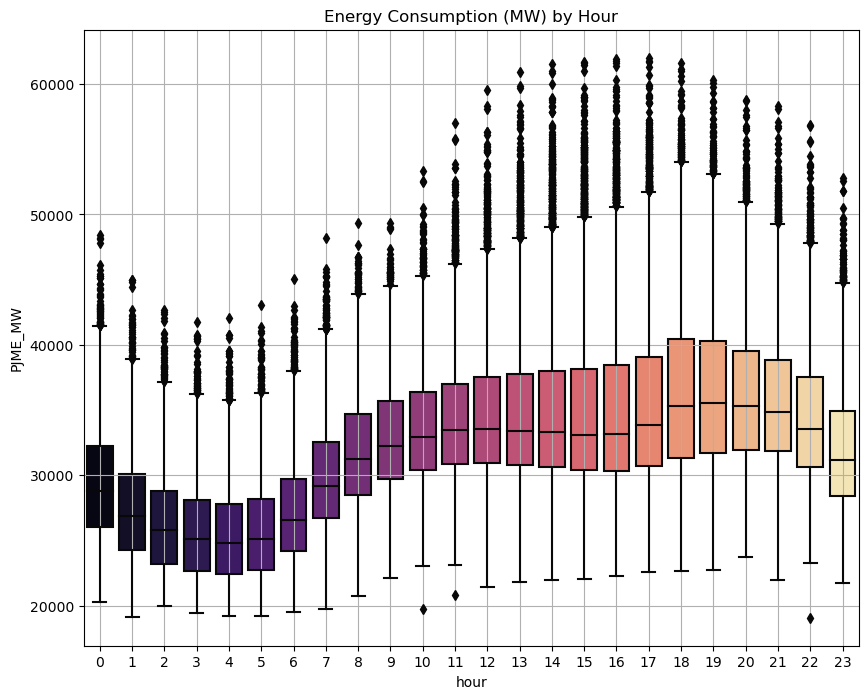

In [27]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y='PJME_MW', palette='magma')
ax.set_title('Energy Consumption (MW) by Hour')
plt.grid(True)

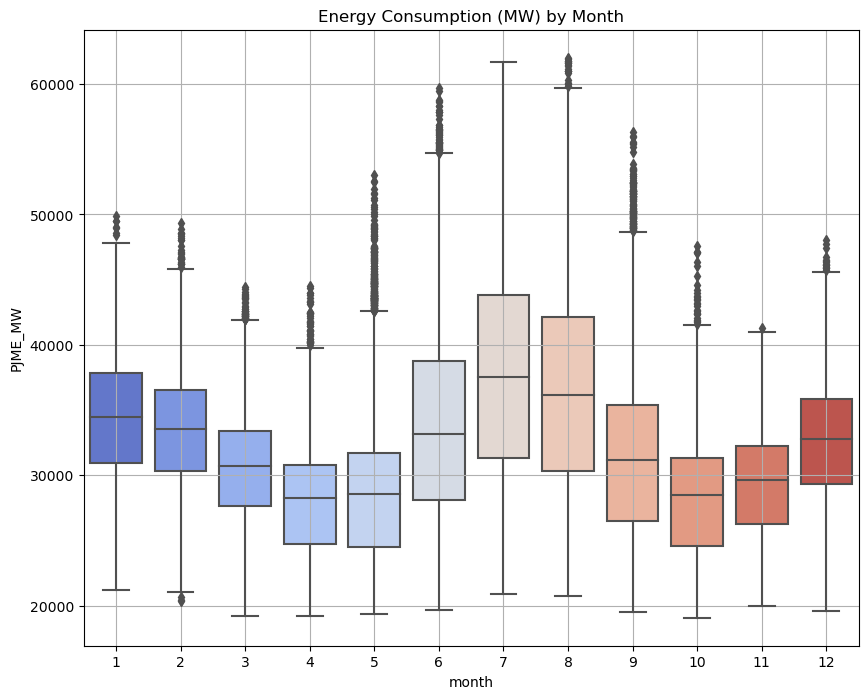

In [28]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='coolwarm')
ax.set_title('Energy Consumption (MW) by Month')
plt.grid(True)

# Train/Test Split

We reserve the data from 2015 and beyond as a test set, and use the data before 2015 as a training set. The following code produces an illustration to help explain this.

Text(0, 0.5, 'Energy Consumption (MW)')

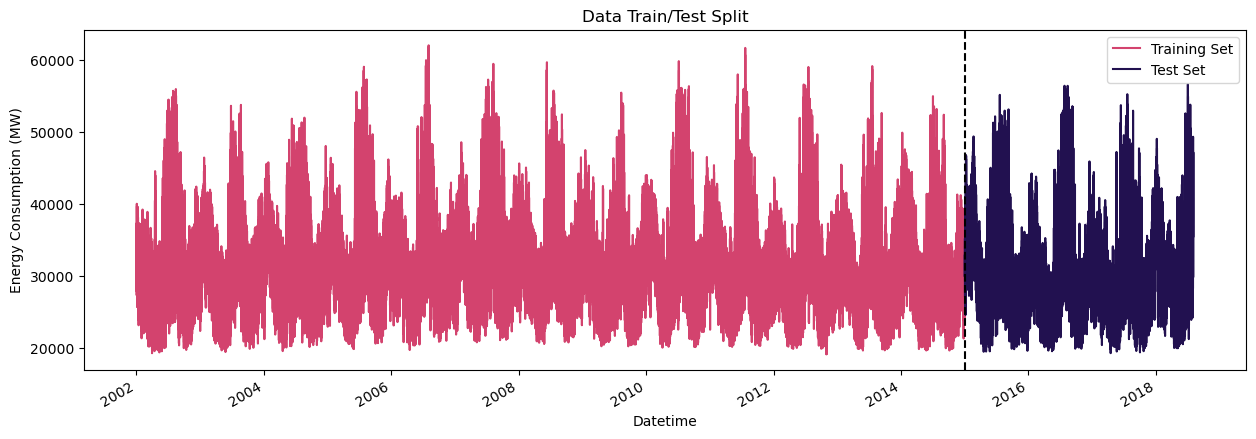

In [29]:
train = df.loc[df.index < '01-01-2015']['PJME_MW']
test = df.loc[df.index >= '01-01-2015']['PJME_MW']

fig, ax = plt.subplots(figsize=(15, 5))

train.plot(ax=ax, 
           label='Training Set',
           title='Data Train/Test Split',
           color=color_pal[3])

test.plot(ax=ax,
          label='Test Set',
          color=color_pal[0])

ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.ylabel('Energy Consumption (MW)')

# **Aside** - Time Series Cross Validation

To implement cross-validation while training a model on time series data, one can use `TimeSeriesSplit` from sklearn.

In [30]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

The following code produces a visualisation to illustrate how the data is structured into a training set and a test set during 5-fold time series cross-validation.

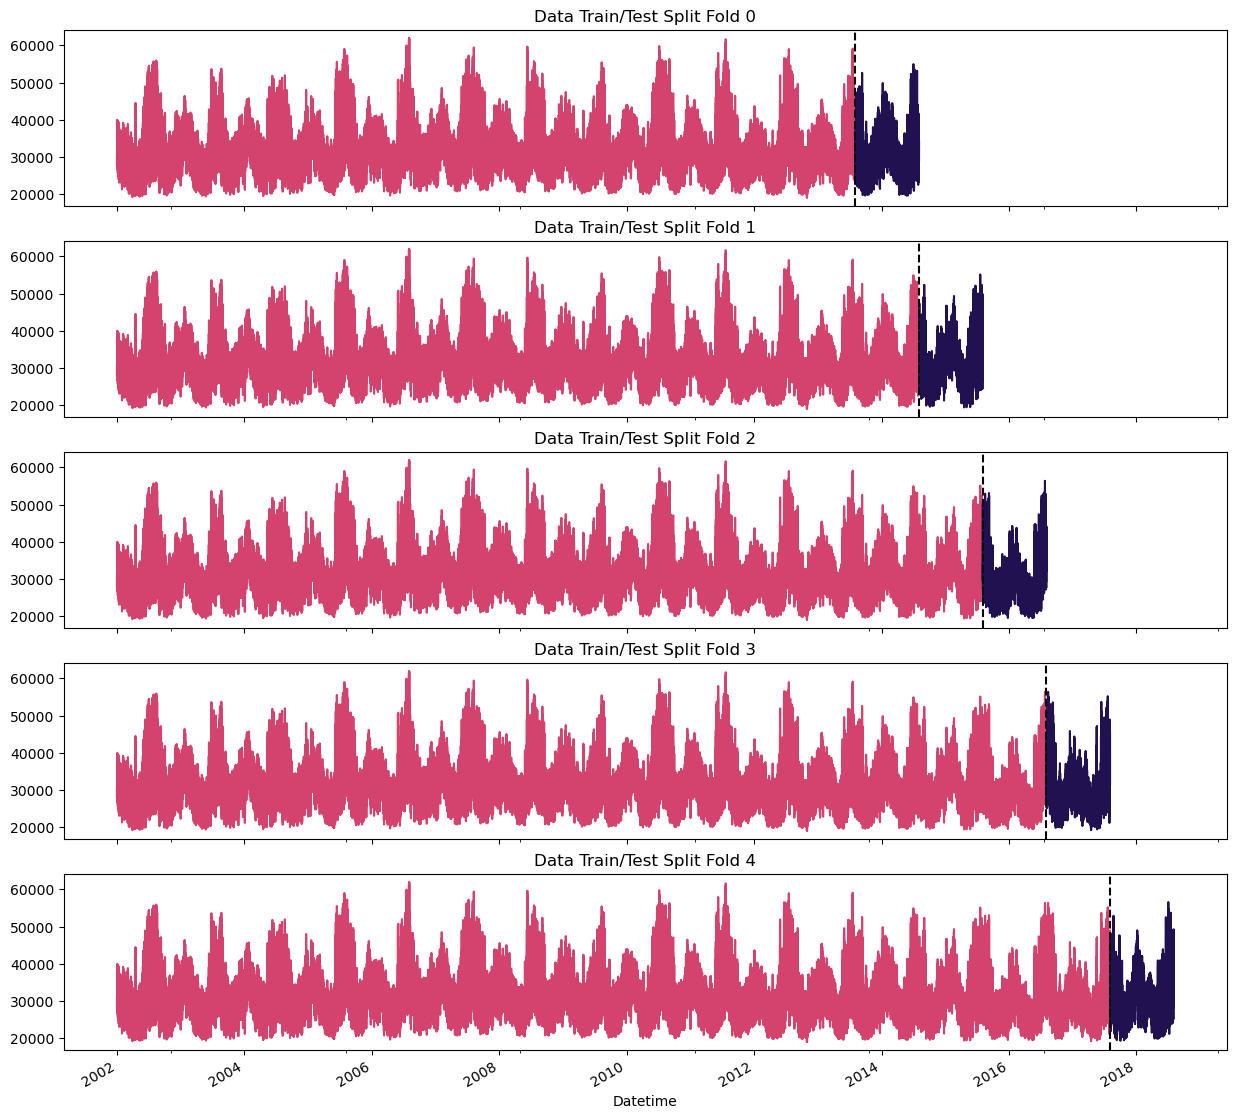

In [31]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}',
                          color=color_pal[3])
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set',
                         color=color_pal[0])
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

## Training using Cross-Validation

The following code trains an `XGBRegressor` on each of the above 5 folds, saving the score (RMSE) in a list `scores`.

In [32]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year', 'lag1', 'lag2', 'lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, 
                           booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    
    reg.fit(X_train, 
            y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.50147	validation_1-rmse:31956.66494
[100]	validation_0-rmse:12532.10915	validation_1-rmse:11906.70125
[200]	validation_0-rmse:5739.78666	validation_1-rmse:5352.86754
[300]	validation_0-rmse:3868.29390	validation_1-rmse:3891.32148
[400]	validation_0-rmse:3428.85875	validation_1-rmse:3753.95996
[456]	validation_0-rmse:3349.18480	validation_1-rmse:3761.64093
[0]	validation_0-rmse:32672.16154	validation_1-rmse:32138.88680
[100]	validation_0-rmse:12513.25338	validation_1-rmse:12222.97626
[200]	validation_0-rmse:5755.14393	validation_1-rmse:5649.54800
[300]	validation_0-rmse:3909.18294	validation_1-rmse:3930.98277
[400]	validation_0-rmse:3477.91771	validation_1-rmse:3603.77859
[500]	validation_0-rmse:3356.63775	validation_1-rmse:3534.18452
[600]	validation_0-rmse:3299.24378	validation_1-rmse:3495.69013
[700]	validation_0-rmse:3258.86466	validation_1-rmse:3470.24780
[800]	validation_0-rmse:3222.68998	validation_1-rmse:3446.36557
[900]	validation_0-rmse:3195.04645	v

In [33]:
scores

[3753.2775219986684,
 3434.3528874818867,
 3475.9138463312997,
 4093.3608331481823,
 3996.298054855067]

In [34]:
print(f'Mean score across folds: {np.mean(scores):0.4f}')
print(f'Fold scores:\n{scores}')

Mean score across folds: 3750.6406
Fold scores:
[3753.2775219986684, 3434.3528874818867, 3475.9138463312997, 4093.3608331481823, 3996.298054855067]


# Predicting on Test Set

## Fitting an `XGBRegressor`

In [35]:
model = xgb.XGBRegressor(base_score=0.5, 
                         booster='gbtree',    
                         n_estimators=1000,
                         early_stopping_rounds=50,
                         objective='reg:squarederror',
                         max_depth=3,
                         learning_rate=0.01)

In [36]:
model.fit(X_train, 
          y_train, 
          eval_set=[(X_train,y_train),(X_test,y_test)],
          verbose=100)

[0]	validation_0-rmse:32462.05402	validation_1-rmse:31463.86930
[100]	validation_0-rmse:12445.22753	validation_1-rmse:11954.79556
[200]	validation_0-rmse:5750.85887	validation_1-rmse:5616.16472
[300]	validation_0-rmse:3949.92308	validation_1-rmse:4154.55799
[400]	validation_0-rmse:3538.33857	validation_1-rmse:3996.70155
[447]	validation_0-rmse:3472.46884	validation_1-rmse:4004.66554


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Feature Importances

In [37]:
fi = pd.DataFrame(data=model.feature_importances_,
                  index=model.feature_names_in_,
                  columns=['Importance'])

<Axes: title={'center': 'Feature Importance'}>

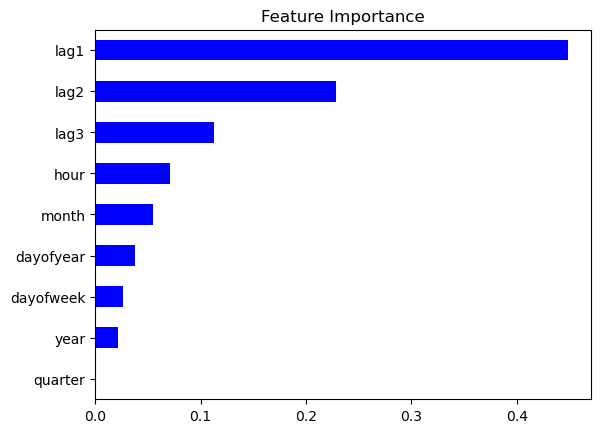

In [38]:
fi.sort_values('Importance').plot(kind='barh',title='Feature Importance',color='blue',legend=False)

## Predictions

In [39]:
train

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2017-08-01 20:00:00,45090.0,20,1,3,8,2017,213,41056.0,46225.0,43934.0
2017-08-01 21:00:00,43843.0,21,1,3,8,2017,213,40151.0,44510.0,42848.0
2017-08-01 22:00:00,41850.0,22,1,3,8,2017,213,38662.0,42467.0,40861.0


In [40]:
test

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,
2017-08-03 01:00:00,29189.0,1,3,3,8,2017,215,28809.0,29952.0,28465.0
2017-08-03 02:00:00,27584.0,2,3,3,8,2017,215,27039.0,27934.0,26712.0
2017-08-03 03:00:00,26544.0,3,3,3,8,2017,215,25881.0,26659.0,25547.0
2017-08-03 04:00:00,26012.0,4,3,3,8,2017,215,25300.0,25846.0,24825.0
2017-08-03 05:00:00,26187.0,5,3,3,8,2017,215,25412.0,25898.0,24927.0
...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,39525.0,38698.0,37330.0


In [41]:
test['prediction'] = model.predict(X_test)
df = df.merge(test[['prediction']],how='left',left_index=True,right_index=True)

In [42]:
test['prediction']

Datetime
2017-08-03 01:00:00    27884.035156
2017-08-03 02:00:00    27147.710938
2017-08-03 03:00:00    26344.050781
2017-08-03 04:00:00    25737.550781
2017-08-03 05:00:00    25737.550781
                           ...     
2018-08-02 20:00:00    40988.347656
2018-08-02 21:00:00    40045.542969
2018-08-02 22:00:00    38405.371094
2018-08-02 23:00:00    36211.242188
2018-08-03 00:00:00    30370.074219
Name: prediction, Length: 8760, dtype: float32

In [43]:
test['prediction'].describe()

count     8760.000000
mean     30520.908203
std       5277.272949
min      21005.292969
25%      26730.913086
50%      30010.917969
75%      33361.808594
max      46170.230469
Name: prediction, dtype: float64

We can visualise the predicted energy consumption for a particular week:

Text(0.5, 1.0, 'Predicted vs. Actual Energy Consumption: 04-01-2018 to 04-08-2018')

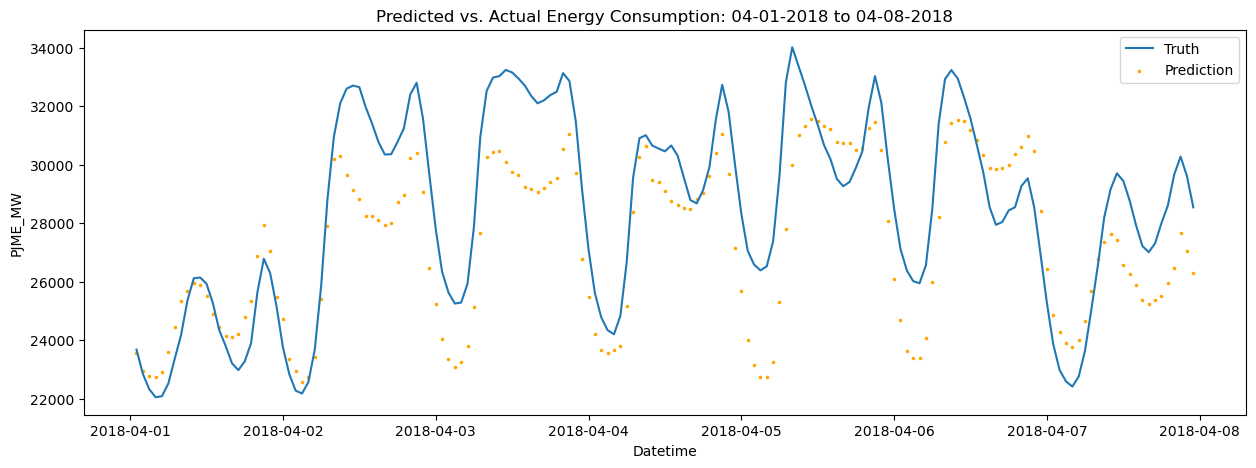

In [44]:
start_date = '04-01-2018'
end_date = '04-08-2018'
filtered_df = df.loc[(df.index > start_date) & (df.index < end_date)]

plt.figure(figsize=(15, 5))
ax = sns.lineplot(data=filtered_df, x=filtered_df.index, y='PJME_MW', label='Truth')
sns.scatterplot(data=filtered_df, x=filtered_df.index, y='prediction', label='Prediction', marker='.',color='orange')
plt.title(f'Predicted vs. Actual Energy Consumption: {start_date} to {end_date}')

# Forecasting the Future

In [45]:
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

In [46]:
model.fit(X_all, 
          y_all,
          eval_set=[(X_all, y_all)],
          verbose=100)

[0]	validation_0-rmse:32403.75596
[100]	validation_0-rmse:12426.47572
[200]	validation_0-rmse:5752.30602
[300]	validation_0-rmse:3971.89168
[400]	validation_0-rmse:3571.56955
[500]	validation_0-rmse:3455.87507
[600]	validation_0-rmse:3402.19853
[700]	validation_0-rmse:3365.64606
[800]	validation_0-rmse:3334.40208
[900]	validation_0-rmse:3308.46216
[999]	validation_0-rmse:3283.79395


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [47]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

Create future dates to predict `PJME_MW` for. We forecast one year beyond the end of the data.

In [48]:
future = pd.date_range('2018-08-03','2019-08-01',freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df,future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [49]:
df_and_future

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3,prediction,isFuture
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN,NaN,NaN,NaN,False
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN,NaN,NaN,NaN,False
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN,NaN,NaN,NaN,False
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,46912.0,39352.0,40243.0,NaN,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,45985.0,38699.0,39183.0,NaN,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,44094.0,37346.0,37759.0,NaN,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,40666.0,34555.0,34641.0,NaN,True


In [50]:
future_w_features = df_and_future.query('isFuture').copy()

In [51]:
future_w_features

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3,prediction,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,33539.0,32094.0,31695.0,NaN,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,30781.0,29503.0,29128.0,NaN,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,29015.0,27712.0,27373.0,NaN,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,27884.0,26535.0,26233.0,NaN,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,27223.0,25870.0,25643.0,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,46912.0,39352.0,40243.0,NaN,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,45985.0,38699.0,39183.0,NaN,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,44094.0,37346.0,37759.0,NaN,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,40666.0,34555.0,34641.0,NaN,True


In [52]:
future_w_features['prediction'] = model.predict(future_w_features[FEATURES])

In [53]:
future_w_features['prediction']

2018-08-03 00:00:00    31290.783203
2018-08-03 01:00:00    29021.386719
2018-08-03 02:00:00    28264.789062
2018-08-03 03:00:00    27622.343750
2018-08-03 04:00:00    27305.328125
                           ...     
2019-07-31 20:00:00    42632.207031
2019-07-31 21:00:00    41855.734375
2019-07-31 22:00:00    40528.839844
2019-07-31 23:00:00    37727.152344
2019-08-01 00:00:00    32205.539062
Name: prediction, Length: 8713, dtype: float32

In [54]:
future_w_features['prediction'].describe()

count     8713.000000
mean     30962.250000
std       5223.142090
min      20941.083984
25%      27205.164062
50%      30601.240234
75%      33895.183594
max      46665.578125
Name: prediction, dtype: float64

Text(0.5, 1.0, 'PJME Energy Consumption, Forecasted with XGBoost')

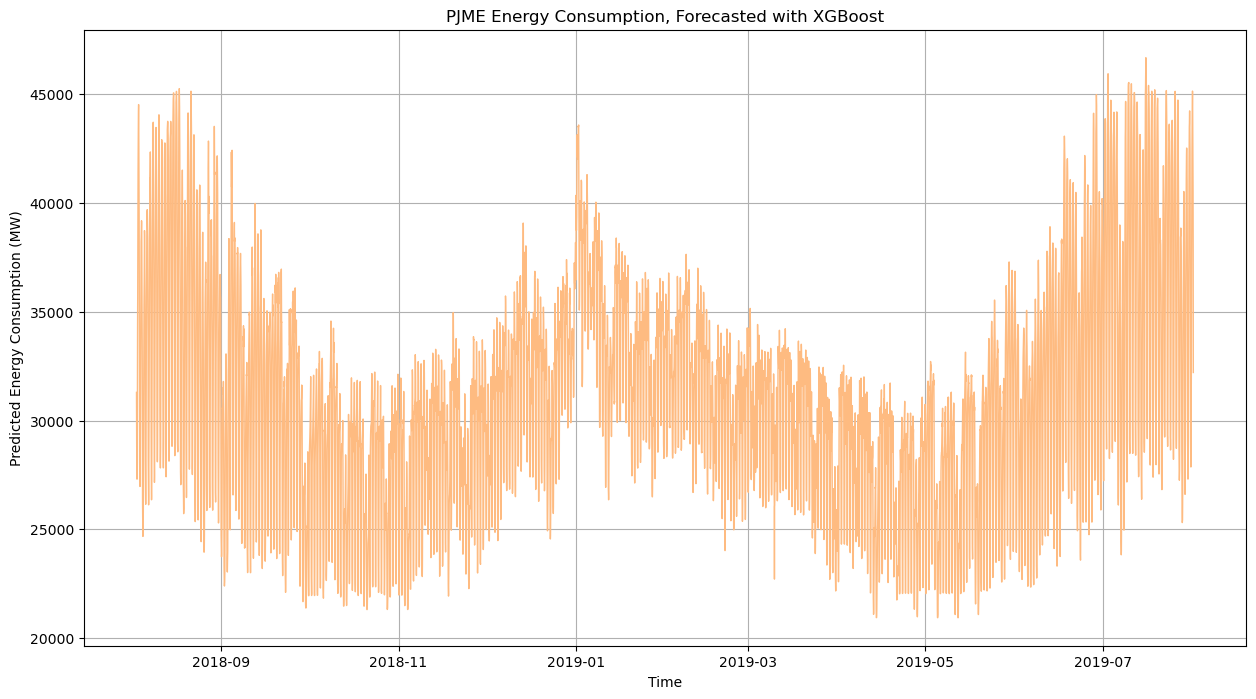

In [55]:
plt.figure(figsize=(15,8))
sns.lineplot(data=future_w_features['prediction'],
             color=color_pal[5],
             ms=1,
             lw=1)
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Predicted Energy Consumption (MW)')
plt.title('PJME Energy Consumption, Forecasted with XGBoost')